In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import scipy.sparse as sparse

In [2]:
mask = hp.read_map('./toast_maps/0/lcdm_telescope_all_time_all_invnpp.fits',verbose=False, dtype=np.float64)
pure_B = sparse.load_npz('pure_B_500.npz')
mask[np.where(mask!=0)] = 1
#mask_apo = mask
mask_apo = nmt.mask_apodization(mask, 5, apotype='C1')

fsky = len(np.where(mask==1)[0])/len(mask)
print(len(np.where(mask==1)[0]))

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


1653


In [3]:
nreal = 100
nside = hp.get_nside(mask)
lmax = 3*nside-1
beam_fwhm = 2.2
npix = hp.nside2npix(nside)
b = nmt.NmtBin.from_nside_linear(nside, 32, is_Dell=True)
ell = b.get_effective_ells()

#beam
#b_ell = hp.gauss_beam(beam_fwhm*np.pi/10800, lmax)

ell_th, TT, EE, BB, TE = np.loadtxt('totcls_lensed_r0p1.txt', unpack=True)
#ell_th, TT, EE, BB, TE = np.loadtxt('test_dls.txt', unpack=True)

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


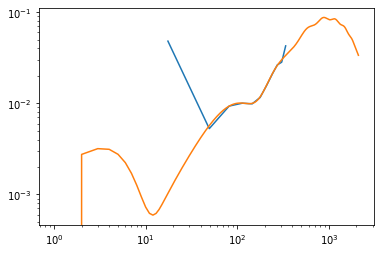

In [42]:
f_pure = nmt.NmtField(mask=mask_apo, maps=mask*hp.read_map('./input_maps/map_0.fits', field=[1,2], verbose=False, dtype=np.float64), n_iter_mask_purify = 10, purify_b = True) #beam = b_ell,
f_mat = nmt.NmtField(mask=np.ones_like(mask_apo), maps=mask*hp.read_map(f'./input_maps/map_0.fits', field=[1,2], verbose=False, dtype=np.float64) ) #beam = b_ell

f_out = nmt.NmtField(mask=mask_apo, maps=mask*hp.read_map('./input_maps/map_0.fits', field=[1,2], verbose=False, dtype=np.float64) ) #beam = b_ell
f_in = nmt.NmtField(mask=np.ones(npix), maps=hp.read_map('./input_maps/map_0.fits', field=[1,2], verbose=False, dtype=np.float64) )#, beam = b_ell)

w_in = nmt.NmtWorkspace()
w_in.compute_coupling_matrix(f_in, f_in, b)

w_out = nmt.NmtWorkspace()
w_out.compute_coupling_matrix(f_out, f_out, b)

w_pure = nmt.NmtWorkspace()
w_pure.compute_coupling_matrix(f_pure, f_pure, b)

w_mat = nmt.NmtWorkspace()
w_mat.compute_coupling_matrix(f_mat, f_mat, b)

cl_th = np.array([EE, np.zeros_like(EE), np.zeros_like(EE), BB])
cl_th_binned = w_pure.decouple_cell(w_pure.couple_cell(cl_th))

prefactor = 2*np.pi/ell/(ell+1)
cl_th_binned *= prefactor

plt.plot(ell, cl_th_binned[3])
plt.plot(ell_th, cl_th[3])
plt.yscale('log')
plt.xscale('log')

In [5]:
# ft_EE = np.load('ft_EE.npy')
#ft_BB = np.load('ft_BB.npy')

transfer = np.load('transfer.npy')


In [6]:
def compute_master(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
#     cl_coupled[0] *= ft_EE
#    cl_coupled[3] *= ft_BB

#    cl_coupled[3] /= apo_transfer

    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled, cl_coupled

In [7]:
# cl_out = []
cl_mean = np.zeros_like(cl_th_binned)
cl_std = np.zeros_like(cl_th_binned)

cl_in_mean = np.zeros_like(cl_th_binned)
cl_in_std = np.zeros_like(cl_th_binned)

# reg_cl_mean = np.zeros_like(cl_th_binned)
# reg_cl_std = np.zeros_like(cl_th_binned)

pure_cl_mean = np.zeros_like(cl_th_binned)
pure_cl_std = np.zeros_like(cl_th_binned)

cl_anafast_mean = np.zeros(lmax+1)
cl_anafast_std = np.zeros(lmax+1)

pcl_mean = np.zeros((4, lmax+1), dtype=np.float64)
pcl_std = np.zeros((4, lmax+1), dtype=np.float64)

#transfer = np.zeros_like(cl_th_binned[0])

for i in range(nreal):
    
    #Full sky
#     f_in = nmt.NmtField(mask=np.ones_like(mask), maps=hp.read_map(f'./input_maps/map_{i}.fits', field=[1,2], verbose=False, dtype=np.float64)) #, beam = b_ell
#     cl_in, _ = compute_master(f_in, f_in, w_in)
#     cl_in_mean += cl_in
#     cl_in_std += cl_in*cl_in

    #REGULAR
#     f_out = nmt.NmtField(mask=mask_apo, maps=mask*hp.read_map(f'./toast_maps/{i}/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64)) #, beam = b_ell
#     cl, pcl = compute_master(f_out, f_out, w_out)
#     reg_cl_mean += cl
#     reg_cl_std += cl*cl
    
    #KS PURIFICATION
    f_pure = nmt.NmtField(mask=mask_apo, maps=mask*hp.read_map(f'./toast_maps/{i}/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64), n_iter_mask_purify=10, purify_b=True) #, beam = b_ell
    cl, pcl = compute_master(f_pure, f_pure, w_pure)
    cl_mean += cl
    cl_std += cl*cl
#     pcl_mean += pcl
#     pcl_std += pcl*pcl
    
    #MAT PURIFICATION
    m = mask_apo*hp.read_map(f'./toast_maps/{i}/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64)
    m_pure = pure_B.dot(np.concatenate(m)).reshape(2, npix)
    f_mat = nmt.NmtField(mask=np.ones_like(mask), maps=[m_pure[0], m_pure[1]]) #beam = b_ell
    
    cl_coupled = nmt.compute_coupled_cell(f_mat, f_mat)
    cl_decoupled = w_mat.decouple_cell(cl_coupled)
    cl_decoupled[3] *= transfer

    pcl = cl_coupled
    cl = cl_decoupled
    
    pure_cl_mean += cl
    pure_cl_std += cl*cl
    
    pcl_mean += pcl
    pcl_std += pcl*pcl
    
#     trans = cl_in[3] / cl[3]
#     transfer += trans
    
    #ana fast
#     m = mask_apo*hp.read_map(f'./toast_maps/{i}/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64)
#     m_pure = pure_B.dot(np.concatenate(m)).reshape(2, npix)
#     cl = hp.anafast([np.zeros(npix), m_pure[0], m_pure[1]])[2]
#     cl_anafast_mean += cl
#     cl_anafast_std += cl*cl

#transfer /= nreal

pcl_mean /= nreal
pcl_std = np.sqrt(pcl_std / nreal - pcl_mean*pcl_mean)

cl_mean /= nreal
cl_std = np.sqrt(cl_std / nreal - cl_mean*cl_mean)

cl_in_mean /= nreal
cl_in_std = np.sqrt(cl_in_std / nreal - cl_in_mean*cl_in_mean)

# reg_cl_mean /= nreal
# reg_cl_std = np.sqrt(reg_cl_std / nreal - reg_cl_mean*reg_cl_mean)

pure_cl_mean /= nreal
pure_cl_std = np.sqrt(pure_cl_std / nreal - pure_cl_mean*pure_cl_mean)

cl_anafast_mean /= nreal
cl_anafast_std = np.sqrt(cl_anafast_std / nreal - cl_anafast_mean*cl_anafast_mean)

#np.save('pcl_no_filt', pcl_mean)

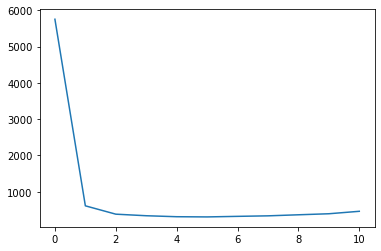

In [8]:
plt.plot(transfer)
#np.save('transfer.npy', transfer)

In [9]:
# m_q, m_u = mask*hp.read_map(f'./out_maps/{i}/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64)
# m_pure = pure_B.dot(np.concatenate([m_q, m_u]))
# m_pure = purified_m.reshape(2, npix)
# cl_anafast = hp.anafast([np.zeros(npix), m_pure[0], m_pure[1]])
# ell_t = ell_th[:lmax+1]
# pref = ell_t*(ell_t+1)/2/np.pi
# plt.loglog(ell_t, pref*cl_anafast[2]/fsky)
# plt.loglog(ell_th, BB, label='Theory BB')


Text(0.5, 1.0, 'BB of r=0.1 maps')

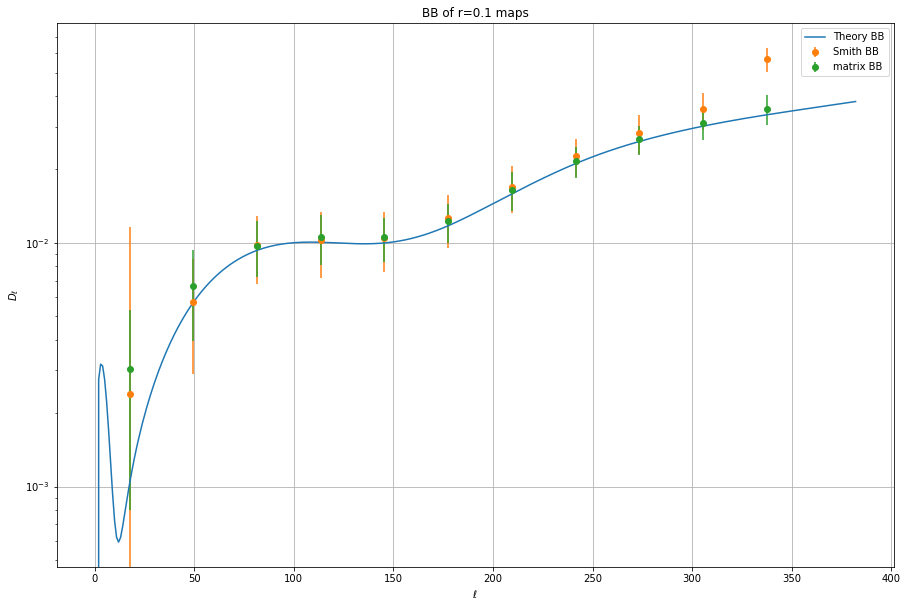

In [10]:
plt.figure(figsize=(15,10)) 
#plt.plot(ell_th, EE, label='Theory EE')
plt.plot(ell_th[:lmax], BB[:lmax], label='Theory BB')

# plt.errorbar(ell, np.mean(cl_in, axis=0)[0], yerr=np.std(cl_in, axis=0)[0], label='input EE, full sky')
# plt.errorbar(ell, np.mean(cl_in, axis=0)[3], yerr=np.std(cl_in, axis=0)[3], label='input BB, full sky')

#plt.errorbar(ell, np.mean(cl_out, axis=0)[0], yerr=np.std(cl_out, axis=0)[0], fmt='.', label='output EE')
#plt.errorbar(ell, reg_cl_mean[3], yerr=reg_cl_std[3], fmt='.', label='regular BB')
#plt.fill_between(ell, reg_cl_mean[3]+reg_cl_std[3], reg_cl_mean[3]-reg_cl_std[3], alpha=0.5)

#plt.errorbar(ell, cl_in_mean[3], yerr=cl_in_std[3], fmt='o', label='fullsky BB')

#plt.errorbar(ell, cl_mean[0], yerr=cl_std[0], fmt='.', label='output EE')
plt.errorbar(ell, cl_mean[3], yerr=cl_std[3], fmt='o', label='Smith BB')
#plt.fill_between(ell, cl_mean[3]+cl_std[3], cl_mean[3]-cl_std[3], alpha=0.5)


#plt.errorbar(ell, pure_cl_mean[0]/fsky, yerr=pure_cl_std[0], fmt='.', label='output EE')
plt.errorbar(ell, pure_cl_mean[3], yerr=pure_cl_std[3], fmt='o', label='matrix BB')
#plt.fill_between(ell, pure_cl_mean[3]/fsky+pure_cl_std[3], pure_cl_mean[3]/fsky-pure_cl_std[3])


# ell_t = ell_th[:lmax+1]
# pref = ell_t*(ell_t+1)/2/np.pi
# plt.errorbar(ell_t, pref*cl_anafast_mean*apo_transfer, yerr=cl_anafast_std, fmt='.', label='matrix BB')


# ell_pcl = np.arange(lmax+1)
# pref=ell_pcl*(ell_pcl+1)/2/np.pi
# #plt.plot(ell_pcl, pcl_mean[0],  label='pseudo EE')
# plt.plot(ell_pcl, pref*pcl_mean[3],  label='pseudo BB')

#binned theory?
# plt.plot(ell, cl_th_binned[0], label='Binned theory BB')
plt.plot(ell, cl_th_binned[3], label='Binned theory BB')

plt.yscale('log')
#plt.xscale('log')
plt.grid()

plt.legend()
plt.xlabel('$\ell$')
plt.ylabel('$D_\ell$')
plt.title('BB of r=0.1 maps')

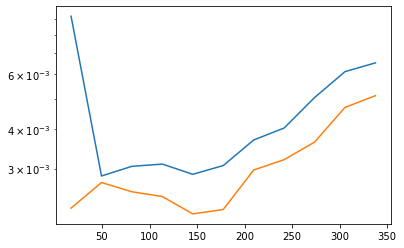

In [37]:
plt.plot(ell, cl_std[3])
plt.plot(ell, pure_cl_std[3])
plt.yscale('log')

In [14]:
# #compute filter transfer
# pcl_filt = np.load('pcl_filt.npy')
# pcl_no_filt = np.load('pcl_no_filt.npy')

# ft_EE = pcl_no_filt[0]/pcl_filt[0]
# ft_BB = pcl_no_filt[3]/pcl_filt[3]

# ft_EE[0]=ft_EE[1] = ft_BB[0] = ft_BB[1] = 0

# np.save('ft_EE', ft_EE)
# np.save('ft_BB', ft_BB)

In [15]:
# plt.plot(ell, np.std(cl_out, axis=0)[3], label='output BB')
# plt.plot(ell, np.std(cl_pure, axis=0)[3], label='purified BB')
# plt.legend()
# plt.xlabel('$\ell$')
# plt.ylabel('$\sigma(D_\ell$)')
# plt.yscale('log')
# plt.xscale('log')
         

In [16]:
# plt.figure(figsize=(20,10)) 
# # plt.plot(ell_theory, EE, label='Theory EE')
# # plt.plot(ell_theory, BB, label='Theory BB')

# #plt.errorbar(ell, filt_EE*EE, yerr=np.std(cl_out, axis=0)[0], fmt='.', label='output EE')
# #plt.errorbar(ell, filt_BB*BB, yerr=np.std(cl_out, axis=0)[3], fmt='.', label='output BB')

# plt.errorbar(ell, EE/ft_EE, yerr=cl_std[0], fmt='.', label='output EE')
# plt.errorbar(ell, BB/ft_BB, yerr=cl_std[3], fmt='.', label='output BB, purified')

# #binned theory?
# plt.plot(ell, cl_th_binned[0], label='Binned theory EE')
# plt.plot(ell, cl_th_binned[3], label='Binned theory BB')

# plt.yscale('log')
# plt.xscale('log')

# plt.legend()
# plt.xlabel('$\ell$')
# plt.ylabel('$D_\ell$')

In [17]:
#f = np.array([np.ones(lmax), np.ones(lmax), np.ones(lmax)])

In [18]:
#m = w_pure.get_coupling_matrix()

In [19]:
# cl_out = []
# cl_pure = []

# for i in range(nreal):

#     #OUTPUT MAPS
#     f_out = nmt.NmtField(mask=mask_apo, maps=mask*hp.read_map(f'./input_maps/map_{i}.fits', field=[1,2], verbose=False, dtype=np.float64), beam=b_ell)
#     cl_out.append(compute_master(f_out, f_out, w_out))
    
#     #PURIFICATION
#     f_pure = nmt.NmtField(mask=mask_apo, maps=mask*hp.read_map(f'./input_maps/map_{i}.fits', field=[1,2], verbose=False, dtype=np.float64), beam=b_ell, n_iter_mask_purify=10, purify_b=True)
#     cl_pure.append(compute_master(f_pure, f_pure, w_pure))


In [20]:
# nside = hp.get_nside(mask)

# th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
# ph[np.where(ph > np.pi)[0]] -= 2 * np.pi

# ph_max = np.max(ph[np.where(mask!=0)])
# ph_min = np.min(ph[np.where(mask!=0)])

# th_max = np.max(th[np.where(mask!=0)])
# th_min = np.min(th[np.where(mask!=0)])

# print(ph_min, ph_max, th_min, th_max)

# ph_center = (ph_min+ph_max)/2
# th_center = (th_min+th_max)/2

# inv_size = 25
# A = 0.15
# w = 1.02
# l = 1.6
# x = 1.75e-2
# y= -0.3e-2

# mask[np.where( np.sqrt(( (( (ph-ph_center+x)*np.cos(A)+(th-th_center+y)*np.sin(A) )/w)**2 + ( ( (ph-ph_center+x)*np.sin(A)+(th-th_center+y)*np.cos(A) )/l)**2 ))<np.pi/inv_size)[0]] = 2


# lon,lat = hp.pix2ang(nside, np.argmax(mask), lonlat=True)
# hp.gnomview(mask, rot=(lon, lat), xsize=800, reso=5)

In [21]:
# mask = np.zeros(hp.nside2npix(nside))
# mask[np.where( np.sqrt(( (( (ph-ph_center+x)*np.cos(A)+(th-th_center+y)*np.sin(A) )/w)**2 + ( ( (ph-ph_center+x)*np.sin(A)+(th-th_center+y)*np.cos(A) )/l)**2 ))<np.pi/inv_size)[0]] = 1
# mask_apo = nmt.mask_apodization(mask, 5, apotype='C1')
# lon,lat = hp.pix2ang(nside, np.argmax(mask), lonlat=True)
# hp.mollview(mask_apo)
# hp.gnomview(mask_apo, rot=(lon, lat), xsize=800, reso=5)

In [22]:
# nside = 128
# mask = np.zeros(hp.nside2npix(nside))
# th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

# ph[np.where(ph > np.pi)[0]] -= 2 * np.pi

# mask[np.where(np.sqrt(ph**2+((th-np.pi/2)/1)**2)<np.pi/25)[0]] = 1.
# mask_apo = nmt.mask_apodization(mask, 5, apotype='C1')

# hp.mollview(mask_apo)

In [23]:
# #check derivatives of mask
# def der1(m):
#     nside = hp.get_nside(m)
#     lmax = 3*nside-1
#     alm_orig = hp.map2alm(m, lmax)
#     m_orig, dtheta, dphi = hp.alm2map_der1(alm_orig, nside, lmax)
#     return m_orig, dtheta, dphi

# m, dtheta, dphi = der1(mask_apo)
# m, dtheta2, dthetaphi = der1(dtheta)
# m, dphitheta, dphi2 = der1(dphi)

# lon,lat = hp.pix2ang(nside, np.argmax(mask), lonlat=True)
# hp.gnomview(dthetaphi, rot=(lon+5, lat-10), xsize=800, reso=5)

In [24]:
# out_map = hp.read_map('./out_maps/0/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64)
# in_map = hp.read_map(f'./input_maps/map_0.fits', field=[1,2], verbose=False, dtype=np.float64)

In [25]:
# hp.mollview(in_map[0])

In [26]:
# m = mask* in_map[0]
# lon,lat = hp.pix2ang(nside, np.argmax(m), lonlat=True)
# hp.gnomview(m, rot=(lon, lat), xsize=800, reso=5)

In [27]:
# m = out_map[0]
# hp.gnomview(m, rot=(lon, lat), xsize=800, reso=5)

In [28]:
# raw = np.load('unfiltered_tod.npy')
# filtered = np.load('filtered_tod.npy')
# # ground = np.load('ground.npy')

In [29]:
# plt.plot(raw)
# plt.xlim([0,100000])

In [30]:
# plt.plot(filtered)
# plt.xlim([0,100000])

In [31]:
# plt.plot(raw)

In [32]:
# from scipy import signal

# f, Pxx = signal.welch(raw, fs=152.58)

# plt.loglog(f, Pxx)

In [33]:
# sos = signal.butter(2, 0.1, 'hp', fs=152.58, output='sos')
# filtered = signal.sosfilt(sos, raw)
# plt.plot(filtered)


In [34]:
# f, Pxx_filt = signal.welch(filtered, fs=152.58)
# plt.loglog(f, Pxx_filt)
# plt.loglog(f, Pxx)